[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SRI-CSL/signal-public/blob/main/colabs/transfer_learning_persuasion_classification.ipynb)

<!-- # **SIGNAL**ing LKML `activity usage` evolution  -->

<!-- <h1 style="font-size:20em;"> <strong>SIGNAL</strong><i>ing</i> <code>persuasion cues</code> in LKML<h1> -->

# SIGNAL*ing* `persuasion cues` in LKML

##### **Copyright 2022 SRI International.**

This project is under the GPL3 License. 
See the [LICENSE](https://www.gnu.org/licenses/gpl-3.0.en.html) file for the full license text.

# 🏃‍♀️ Quickstart

## 🪄 Install `needed` libraries


In [87]:
import os

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, precision_score, recall_score)
from sklearn.model_selection import (GridSearchCV, cross_val_score, train_test_split)

In [ ]:
# Load preprocessed data and remove unnecessary columns
ser_algo = 'https://raw.githubusercontent.com/SRI-CSL/signal-public/main/colabs/ser.py'
!wget --no-cache --backups=1 {ser_algo}

try:
  # transfer learning setup for the Random forest classifier
  import ser
except:
  !wget --no-cache --backups=1 {ser_algo}
  import ser

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
np.random.seed(0)

## ⚙ Define `helper` functions

In [4]:
from itertools import islice

# a few helper methods
def take(n, iterable):
  "Return first n items of the iterable as a list"
  return list(islice(iterable, n))

def take_from_dict(n, d):
  return take(n, d.items())

In [5]:
def print_results(results):
  print('BEST PARAMS: {}\n'.format(results.best_params_))

  means = results.cv_results_['mean_test_score']
  stds = results.cv_results_['std_test_score']
  for mean, std, params in zip(means, stds, results.cv_results_['params']):
    print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [6]:
def get_best_estimator(clf, X, y, **fit_params):
  f_dict = dict()
  f_dict.update(fit_params)
  cv = GridSearchCV(clf, f_dict, cv=5)
  cv.fit(X, y)
  print_results(cv)
  return cv.best_estimator_

In [52]:
def get_label(y_pred, mapping):
  if len(y_pred) == 0:
    raise ValueError("Nothing to humanize")
  
  y_pred = y_pred[0]
  return mapping.get(y_pred, "Unknown strategy")

In [8]:
def pad_to_dense(M, maxlen=100):
  """thx to https://stackoverflow.com/questions/37676539:
  Appends the minimal required amount of zeroes at the end of each 
  array in the jagged array `M`, such that `M` looses its jaggedness.
  """
  Z = np.zeros((len(M), maxlen))
  for enu, row in enumerate(M):
    Z[enu, :len(row)] += row 
  return Z

In [9]:
def get_padded_input_vector(tfidf, text, shape):
  return pad_to_dense(tfidf.transform([text]).toarray(), shape[1])

In [60]:
def predict_persuasion(txt, model, transformer, mapping, maxlen, padding=False):
  X_pad = None
  if padding:
    X_pad = get_padded_input_vector(transformer, txt, (1, maxlen))
  else:
    X_pad = transformer.transform([txt])
  y_pred = model.predict(X_pad)
  
  label = get_label(y_pred, mapping)
  conf = model.predict_proba(X_pad)[0]
  conf = round(max(conf), 3)
  output = {'label': label, 'confidence': conf}
  return output

## 🧹 Data cleaning and preparation

This section takes the existing P4G dataset and then prepare them to perform persuasion classification.
If the `dialog_data.csv` is available, the next series of steps are then optional and one move directly to the cell the loads this file.

In [10]:
if os.path.exists('../data/dialog_data.csv'):
  print('Go to step: "Re-load dialog_data.csv data"')
else: 
  print('Continue with step: "Re-process dialog_data.csv data"')

Go to step: "Re-load dialog_data.csv data"


### Re-process `dialog_data.csv` data

In [ ]:
# data are available locally.
# In Colab mode, this variable should be set to False
IS_LOCAL_FILE = True

In [ ]:
P4G_dialogs_xlsx = '300_dialog.xlsx'

In [ ]:
# Load preprocessed data and remove unnecessary columns
data_file = f'https://raw.githubusercontent.com/SRI-CSL/signal-public/main/data/{P4G_dialogs_xlsx}'
if IS_LOCAL_FILE:
  data_file = f'../data/{P4G_dialogs_xlsx}'
  if not os.path.exists(data_file):
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1qw9CVHSH9gSpgVNmRH62IAF3tiJTjqC0' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1qw9CVHSH9gSpgVNmRH62IAF3tiJTjqC0" -O '300_dialog.xlsx' && rm -rf /tmp/cookies.txt
  else:
    print(f"{data_file} already exist!")

../data/300_dialog.xlsx already exist!


In [ ]:
dialogs_df = pd.read_excel(data_file)

In [ ]:
dialogs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10864 entries, 0 to 10863
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  10864 non-null  int64  
 1   B2          10864 non-null  object 
 2   B4          10864 non-null  int64  
 3   Turn        10864 non-null  int64  
 4   Unit        10864 non-null  object 
 5   er_label_1  6017 non-null   object 
 6   ee_label_1  4847 non-null   object 
 7   er_label_2  22 non-null     object 
 8   ee_label_2  15 non-null     object 
 9   neg         10235 non-null  float64
 10  neu         10235 non-null  float64
 11  pos         10235 non-null  float64
dtypes: float64(3), int64(3), object(6)
memory usage: 1018.6+ KB


In [ ]:
dialogs_df.head(1)

,Unnamed: 0,B2,B4,Turn,Unit,er_label_1,ee_label_1,er_label_2,ee_label_2,neg,neu,pos
0,0,20180719-210146_172_live,0,0,Hello.,greeting,NaN,NaN,NaN,0.0,1.0,0.0


In [ ]:
dialogs_df.values[pd.isna(dialogs_df.values)] = None

In [ ]:
# get all the columns where 'er_label_1' is not NaN
er_1_df = dialogs_df[dialogs_df['er_label_1'].notna()]

In [ ]:
er_1_df.head()

,Unnamed: 0,B2,B4,Turn,Unit,er_label_1,ee_label_1,er_label_2,ee_label_2,neg,neu,pos
0,0,20180719-210146_172_live,0,0,Hello.,greeting,NaN,NaN,NaN,0.0,1.000,0.000
1,1,20180719-210146_172_live,0,0,How are you?,greeting,NaN,NaN,NaN,0.0,1.000,0.000
3,3,20180719-210146_172_live,0,1,Very well.,greeting,NaN,NaN,NaN,0.0,0.295,0.705
4,4,20180719-210146_172_live,0,1,I'm just up organizing info for my charity.,other,NaN,NaN,NaN,0.0,0.714,0.286
5,5,20180719-210146_172_live,0,1,Are you involved with charities?,task-related-inquiry,NaN,NaN,NaN,0.0,0.556,0.444


In [ ]:
strategy_subset = {
  'logical-appeal', 'emotion-appeal', 'credibility-appeal', 'foot-in-the-door', 
  'self-modeling', 'personal-story', 'donation-information', 'source-related-inquiry',
  'task-related-inquiry', 'personal-related-inquiry'}

In [ ]:
filtered_er_1_df = er_1_df.loc[er_1_df['er_label_1'].isin(strategy_subset)]

In [ ]:
dialog_dataset_df = filtered_er_1_df.loc[:, ('Unit', 'er_label_1')]

In [ ]:
dialog_dataset_df.rename(columns={"Unit": "text", "er_label_1": "persuasion"}, inplace=True)

In [ ]:
dialog_dataset_df.head()

,text,persuasion,persuasion_id
5,Are you involved with charities?,task-related-inquiry,0
18,Do you currently donate to your charity?,task-related-inquiry,0
22,Save The Children is an international non-gove...,credibility-appeal,1
28,These children really need the assistance.,logical-appeal,2
34,Do you have any more questions for me?,task-related-inquiry,0


In [ ]:
dialog_dataset_df.to_csv('../data/dialog_data.csv', index=False)

### Re-load `dialog_data.csv` data

In [11]:
# Guard clause to determine if the dialog_data.csv is indeed available
# Raise an error if it is not.
assert os.path.exists('../data/dialog_data.csv')

dialog_dataset_df = pd.read_csv('../data/dialog_data.csv')

### Data preparation

In [12]:
dialog_dataset_df['persuasion_id'] = dialog_dataset_df['persuasion'].factorize()[0]
er_dict_df = dialog_dataset_df[['persuasion', 'persuasion_id']].drop_duplicates().sort_values('persuasion_id')

In [13]:
label2idx = dict(er_dict_df.values)
take_from_dict(len(label2idx), label2idx)

[('task-related-inquiry', 0),
 ('credibility-appeal', 1),
 ('logical-appeal', 2),
 ('personal-related-inquiry', 3),
 ('source-related-inquiry', 4),
 ('donation-information', 5),
 ('foot-in-the-door', 6),
 ('emotion-appeal', 7),
 ('self-modeling', 8),
 ('personal-story', 9)]

In [14]:
idx2label = dict(er_dict_df[['persuasion_id', 'persuasion']].values)
take_from_dict(len(idx2label), idx2label)

[(0, 'task-related-inquiry'),
 (1, 'credibility-appeal'),
 (2, 'logical-appeal'),
 (3, 'personal-related-inquiry'),
 (4, 'source-related-inquiry'),
 (5, 'donation-information'),
 (6, 'foot-in-the-door'),
 (7, 'emotion-appeal'),
 (8, 'self-modeling'),
 (9, 'personal-story')]

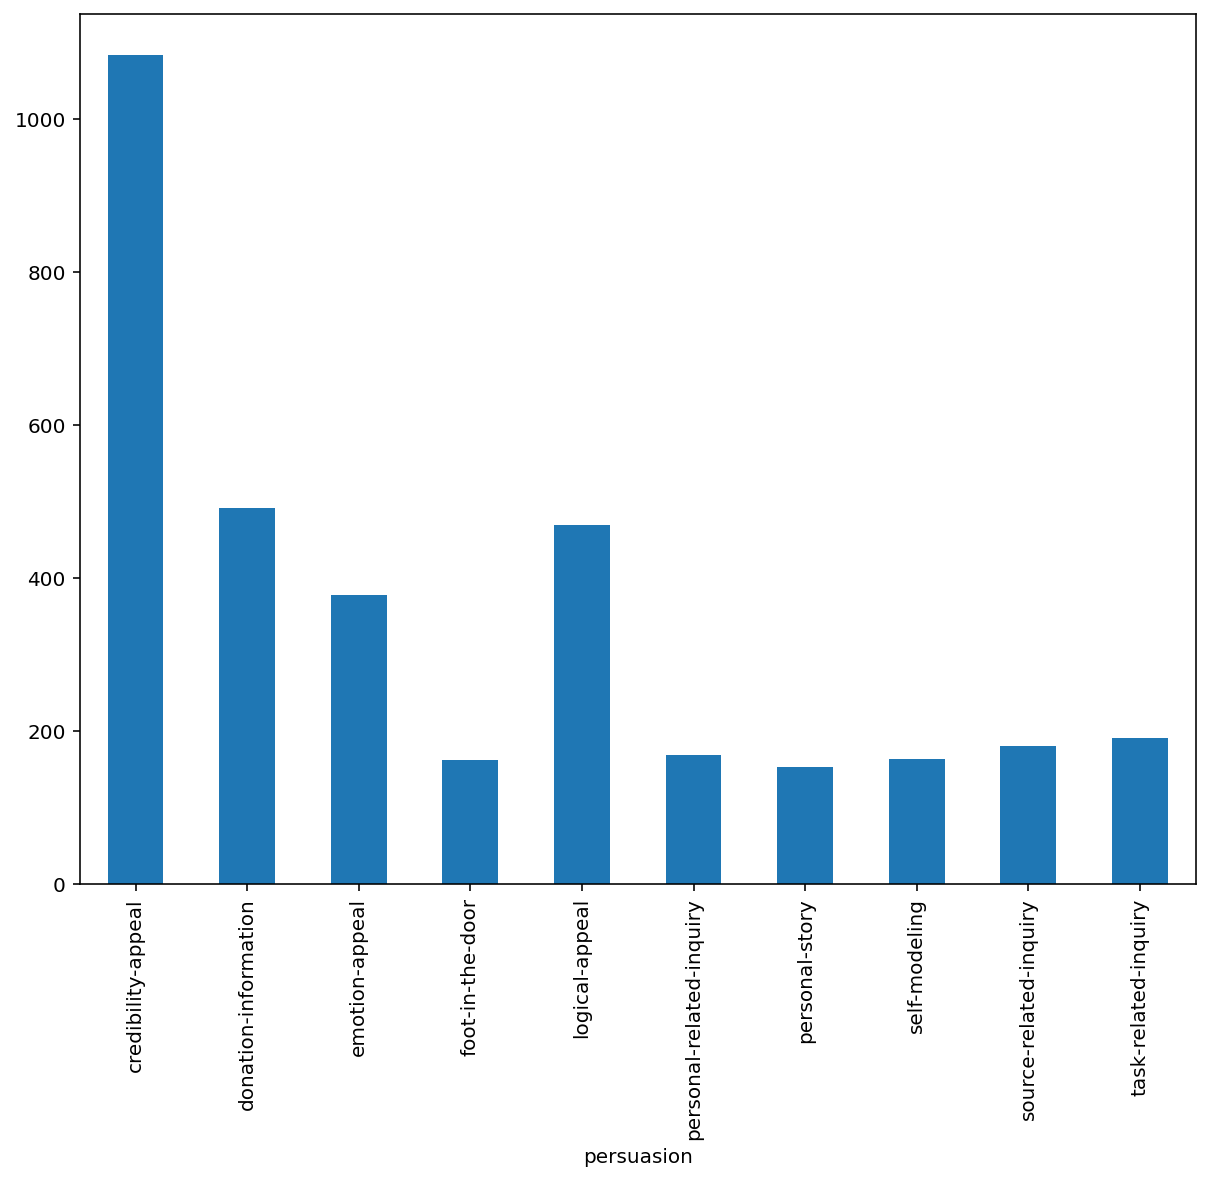

In [15]:
fig = plt.figure(figsize=(10,8))
dialog_dataset_df.groupby('persuasion').text.count().plot.bar(ylim=0)
plt.show()

In [16]:
# Max features in 'source' and in 'target'
N_FEATURES_SRC = 600
N_FEATURES_TGT = 602

In [17]:
X = dialog_dataset_df['text'][:N_FEATURES_SRC]
y = dialog_dataset_df['persuasion_id'].to_numpy()[:N_FEATURES_SRC]

In [18]:
X.shape, y.shape

((600,), (600,))

In [19]:
# vectorize text
tfidf = TfidfVectorizer(
  sublinear_tf=True, 
  min_df=2, 
  norm='l2', 
  encoding='latin-1', 
  ngram_range=(1, 2), 
  stop_words='english')

In [20]:
# X = tfidf.fit_transform(dialog_dataset_df.text).toarray()
X_src = tfidf.fit_transform(X).toarray()
y_src = y
print(f'n_samples: {X_src.shape[0]}, n_features: {X_src.shape[1]}')

n_samples: 600, n_features: 626


In [21]:
X_src.shape, y_src.shape

((600, 626), (600,))

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_src, y_src, test_size = 0.4, random_state = 42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 42)

In [23]:
for dataset in [y_train, y_val, y_test]:
  print(round(len(dataset) / len(y), 2))

0.6
0.2
0.2


In [24]:
X_train.shape, X_test.shape

((360, 626), (120, 626))

## 🌳 Train a basic Random Forest classifier using cross validation

In [25]:
# Fit a basic 🍬 model using cross validation
acc_RF = cross_val_score(RandomForestClassifier(), X_src, y_src, scoring='accuracy', cv=5)
print(f'max acc: {np.max(acc_RF)}')

max acc: 0.575


In [26]:
# 🚀 Tune hyper-parameters
model = get_best_estimator(
  RandomForestClassifier(), 
  X_train, 
  y_train, 
  n_estimators=[5, 10, 15, 20], 
  max_depth=[2, 4, 8, 16, 32, None])

model

BEST PARAMS: {'max_depth': 32, 'n_estimators': 20}

0.358 (+/-0.064) for {'max_depth': 2, 'n_estimators': 5}
0.383 (+/-0.074) for {'max_depth': 2, 'n_estimators': 10}
0.342 (+/-0.052) for {'max_depth': 2, 'n_estimators': 15}
0.381 (+/-0.057) for {'max_depth': 2, 'n_estimators': 20}
0.392 (+/-0.054) for {'max_depth': 4, 'n_estimators': 5}
0.414 (+/-0.081) for {'max_depth': 4, 'n_estimators': 10}
0.419 (+/-0.054) for {'max_depth': 4, 'n_estimators': 15}
0.397 (+/-0.052) for {'max_depth': 4, 'n_estimators': 20}
0.439 (+/-0.057) for {'max_depth': 8, 'n_estimators': 5}
0.433 (+/-0.051) for {'max_depth': 8, 'n_estimators': 10}
0.458 (+/-0.05) for {'max_depth': 8, 'n_estimators': 15}
0.453 (+/-0.057) for {'max_depth': 8, 'n_estimators': 20}
0.472 (+/-0.03) for {'max_depth': 16, 'n_estimators': 5}
0.478 (+/-0.078) for {'max_depth': 16, 'n_estimators': 10}
0.497 (+/-0.064) for {'max_depth': 16, 'n_estimators': 15}
0.483 (+/-0.085) for {'max_depth': 16, 'n_estimators': 20}
0.469 (+/-0.103) for {

RandomForestClassifier(max_depth=32, n_estimators=20)

In [27]:
candidate_models = [
  RandomForestClassifier(n_estimators=15, max_depth=16), 
  RandomForestClassifier(n_estimators=15, max_depth=32), 
  RandomForestClassifier(n_estimators=20, max_depth=None),
  RandomForestClassifier(n_estimators=20, max_depth=16)]

for idx in range(len(candidate_models)):
  candidate_models[idx].fit(X_train, y_train)

candidate_models += [model]
print(f"no models to be validated: {len(candidate_models)}")

no models to be validated: 5


In [28]:
# Evaluate results on validation set
for idx, mdl in enumerate(candidate_models):
  y_pred = mdl.predict(X_val)
  accuracy = round(accuracy_score(y_val, y_pred), 3)
  precision = round(precision_score(y_val, y_pred, average='micro'), 3)
  recall = round(recall_score(y_val, y_pred, average='micro'), 3)
  
  print(f'{idx} - MAX DEPTH: {mdl.max_depth} / # OF EST: {mdl.n_estimators} -- A: {accuracy} / B: {precision} / C: {recall}')

0 - MAX DEPTH: 16 / # OF EST: 15 -- A: 0.458 / B: 0.458 / C: 0.458
1 - MAX DEPTH: 32 / # OF EST: 15 -- A: 0.492 / B: 0.492 / C: 0.492
2 - MAX DEPTH: None / # OF EST: 20 -- A: 0.517 / B: 0.517 / C: 0.517
3 - MAX DEPTH: 16 / # OF EST: 20 -- A: 0.467 / B: 0.467 / C: 0.467
4 - MAX DEPTH: 32 / # OF EST: 20 -- A: 0.492 / B: 0.492 / C: 0.492


In [29]:
# final model selection and evaluation on test set
best_perf_model = candidate_models[2]

y_pred = best_perf_model.predict(X_test)
accuracy = round(accuracy_score(y_test, y_pred), 3)
precision = round(precision_score(y_test, y_pred, average='micro'), 3)
recall = round(recall_score(y_test, y_pred, average='micro'), 3)

print(f'MAX DEPTH: {best_perf_model.max_depth} / # OF EST: {best_perf_model.n_estimators} -- A: {accuracy} / B: {precision} / C: {recall}')

MAX DEPTH: None / # OF EST: 20 -- A: 0.517 / B: 0.517 / C: 0.517


In [62]:
# 🔥 Examples of persuasion inference
predict_persuasion(
  "They help in the children's basic need like food and clothing",
  best_perf_model,
  tfidf,
  idx2label,
  X_src.shape[1])

{'label': 'credibility-appeal', 'confidence': 0.65}

In [63]:
predict_persuasion(
  "Every little bit helps",
  best_perf_model,
  tfidf,
  idx2label,
  X_src.shape[1])

{'label': 'foot-in-the-door', 'confidence': 1.0}

In [64]:
predict_persuasion(
  "These children really need assistance",
  best_perf_model,
  tfidf,
  idx2label,
  X_src.shape[1])

{'label': 'logical-appeal', 'confidence': 0.7}

# 🍃 Transfer learning on trees using SER

Transfer learning setup for Sklearn's Random Forest Classifier.

In [33]:
# Get the dev_dialog_data.csv
assert os.path.exists('../data/dev_dialog_data.csv')
dev_dialog_data_df = pd.read_csv('../data/dev_dialog_data.csv')

In [34]:
dev_dialog_data_df.head()

,text,persuasion,persuasion_id
0,Are you involved with kernel modifications?,task-related-inquiry,0
1,Do you currently implicit declaration of funct...,task-related-inquiry,0
2,I would rather avoid breeding chain includes; ...,credibility-appeal,1
3,The kernel needs Rust support,logical-appeal,2
4,Add a CPUFreq driver which utilizes a fine gra...,task-related-inquiry,0


In [35]:
# vectorize text
dev_tfidf = TfidfVectorizer(
  sublinear_tf=True, 
  min_df=2, 
  norm='l2', 
  encoding='latin-1', 
  ngram_range=(1, 2), 
  stop_words='english')

In [36]:
X_tgt = dev_tfidf.fit_transform(dev_dialog_data_df.text).toarray()
y_tgt = dev_dialog_data_df.persuasion_id.to_numpy()

In [37]:
X_tgt.shape, y_tgt.shape

((150, 176), (150,))

In [38]:
X_tgt = pad_to_dense(X_tgt, X_src.shape[1])
X_tgt.shape

(150, 626)

In [39]:
# separating 5% & 95% of target data, stratified, random
X_tgt_090, X_tgt_010, y_tgt_090, y_tgt_010 = train_test_split(X_tgt, y_tgt, test_size=0.10, stratify=y_tgt)

In [40]:
# sanity check
X_tgt_090.shape, y_tgt_090.shape

((135, 626), (135,))

In [41]:
ttl_model =  ser.TreesTransferLearning(best_perf_model, bootstrap_=True)
ttl_model.fit(X_tgt_090, y_tgt_090)

tune_rf: 100%|██████████| 20/20 [34:43<00:00, 104.17s/it, trial=19]


TreesTransferLearning(module=RandomForestClassifier(n_estimators=20))

In [71]:
pred_i = predict_persuasion(
  "anything should have a BoF at the KS.",
  ttl_model,
  dev_tfidf,
  idx2label,
  X_src.shape[1], 
  padding=True)
pred_i

{'label': 'logical-appeal', 'confidence': 0.454}

### Save `Transfer learned Random Forest` models

(do this only if you have retrained our developer persuasion model from scratch)

In [48]:
pickle.dump(ttl_model, open('../models/tl_rf_model_03192022.pkl', 'wb'))
pickle.dump(dev_tfidf, open('../models/dev_tfidf_03192022.pkl', 'wb'))

### Load `Transfer learned Random Forest` models

In [68]:
dev_tfidf_ = joblib.load('../models/dev_tfidf_03192022.pkl')
tl_rf_mdl_ = joblib.load('../models/tl_rf_model_03192022.pkl')

In [76]:
pred_j = predict_persuasion(
  "anything should have a BoF at the KS.",
  tl_rf_mdl_,
  dev_tfidf_,
  idx2label,
  X_src.shape[1], 
  padding=True)

# prediction before and after persisting model
pred_i == pred_j

True

In [81]:
# get confusion matrix over testing sets
predictions_test_set = tl_rf_mdl_.module.predict(X_tgt_010)
predictions_test_set

array([1, 4, 1, 2, 1, 1, 1, 1, 7, 5, 7, 2, 0, 8, 2])

In [82]:
cf_matrix = confusion_matrix(y_tgt_010, predictions_test_set)
cf_matrix

array([[0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 2, 0, 0, 0, 2, 0],
       [1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 0, 0]])

In [84]:
class_names = [idx2label[key] for key in idx2label]
class_names

['task-related-inquiry',
 'credibility-appeal',
 'logical-appeal',
 'personal-related-inquiry',
 'source-related-inquiry',
 'donation-information',
 'foot-in-the-door',
 'emotion-appeal',
 'self-modeling',
 'personal-story']

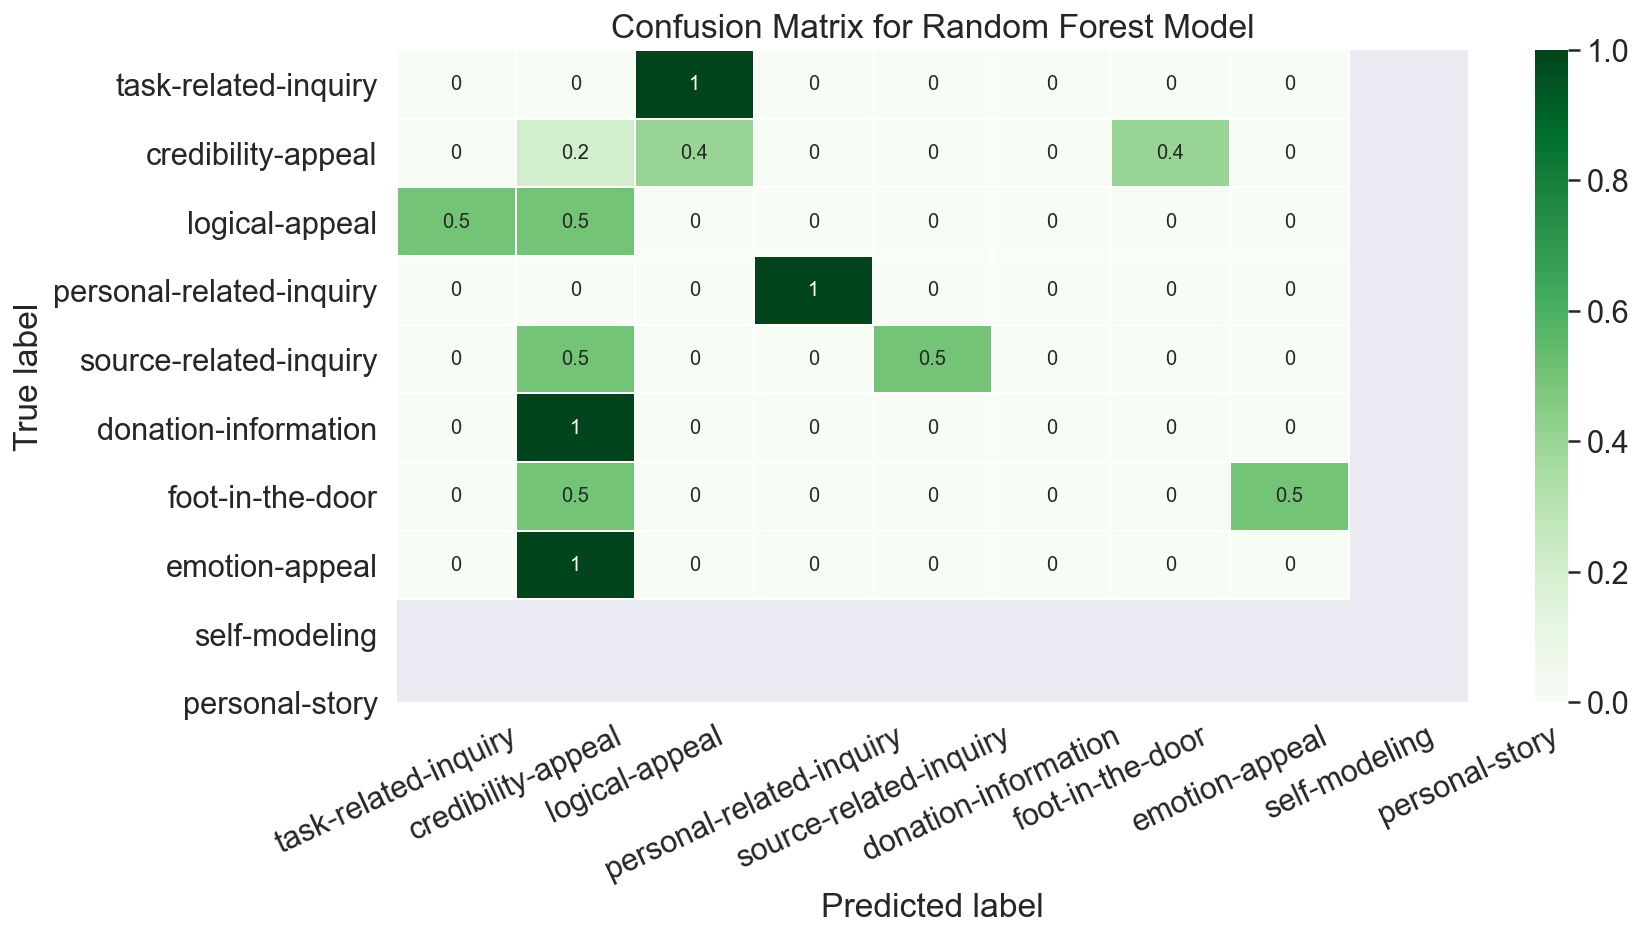

In [85]:
import seaborn as sns

# Get and reshape confusion matrix data
cf_matrix = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
# Build the plot
plt.figure(figsize=(12,6))
sns.set(font_scale=1.4)
sns.heatmap(cf_matrix, annot=True, annot_kws={'size':10}, cmap=plt.cm.Greens, linewidths=0.2)

tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

# 🏃🏽‍♂️ Run the SER Random Forest Model

💪 Run this model against a few developer communications

In [89]:
predict_persuasion(
  "It looks like a generic issue in dynamically toggling APICv scheme.",
  tl_rf_mdl_,
  dev_tfidf_,
  idx2label,
  X_src.shape[1], 
  padding=True)

{'label': 'credibility-appeal', 'confidence': 0.95}

In [90]:
predict_persuasion(
  "In particular, Pathname resolution is not locking-agnostic.",
  tl_rf_mdl_,
  dev_tfidf_,
  idx2label,
  X_src.shape[1], 
  padding=True)

{'label': 'foot-in-the-door', 'confidence': 0.6}

In [91]:
predict_persuasion(
  "The kernel needs Rust support",
  tl_rf_mdl_,
  dev_tfidf_,
  idx2label,
  X_src.shape[1], 
  padding=True)

{'label': 'logical-appeal', 'confidence': 0.65}